In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
from matplotlib import pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from scipy.stats import shapiro
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_colwidth', None)
import itertools

In [2]:
#Подключимся к БД

from vertica_python import connect
connection = connect(
    host='dwh.twiket.com',
    port=5433,
    user='akobtseva',
    password='Lg7@01R#S!3D4z'
    )

## 1. Сезонность 

In [3]:
seasons = f"""
with activity_info as
(select o.inn, legalName, first_orderdate, vid, o.bid, o.email,
count(distinct(orderid)) as orders, sum(gmv) as gmv, sum(revenue) as revenue, date_trunc('quarter', orderdatecreated::date) as quarter,
date_trunc('year', orderdatecreated::date) as year,
TO_CHAR(date_trunc('quarter', orderdatecreated::date), 'MM') as quarter_num,
case when orderdatecreated::date >= sysdate()::date - 365
then 'заказ меньше года назад'
else 'заказ больше года назад'
end as year_order,
date_trunc('quarter', first_orderdate::date) as quarter_first,
max_date - first_orderdate::date as life_time,
sysdate()::date - max_date as recency,
case when sysdate()::date - first_orderdate::date < 365
then 'меньше года'
when sysdate()::date - first_orderdate::date >= 365 and sysdate()::date - first_orderdate::date <= 730
then '1-2 года'
else 'больше 2 лет'
end as type,
case when cnt >= 5
then 'покупал хотя бы 5 кварталов'
else 'покупал реже'
end as frequency,
first_orderdate::date as min_date
from cdm.vg_b2b_contracts_orders_v o
left join bi.dim_buyer b on o.bid = b.buyerId
join (select max(orderdatecreated::date) as max_date, inn from cdm.vg_b2b_contracts_orders_v
           where orderdatecreated >= sysdate()::date - 365 and status = 'Issued' group by inn) o2
on o.inn = o2.inn
join (select count(distinct(date_trunc('quarter', orderdatecreated::date))) as cnt, inn from cdm.vg_b2b_contracts_orders_v
           where orderdatecreated >= sysdate()::date - 1095 and status = 'Issued' group by inn) o3
on o.inn = o3.inn
where orderdatecreated >= sysdate()::date - 1095 and status = 'Issued' and is_test = False
group by o.inn, legalName, o.email, first_orderdate::date, vid, o.bid, date_trunc('quarter', orderdatecreated::date), max_date, type, frequency, quarter_first, TO_CHAR(date_trunc('quarter', orderdatecreated::date), 'MM'), year_order, date_trunc('year', orderdatecreated::date)
order by o.inn, date_trunc('quarter', orderdatecreated::date)
),
t2 as
(select
    distinct *,
    orders/(median(orders) over (partition by bid, year)) as orders_rate
from activity_info)
select
    distinct *,
    median(orders_rate) over (partition by bid, quarter_num) as seasonal_index,
    min(orders_rate) over (partition by bid, quarter_num) as min_rate,
    max(orders_rate) over (partition by bid, quarter_num) as max_rate
from t2
"""
df = pd.read_sql(seasons, connection)

/tmp/ipykernel_223688/817137290.py:49: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(seasons, connection)


In [4]:
new_clients = df[df['type'] == 'меньше года']
old_freq_clients = df[(df['type'] == 'больше 2 лет') & (df['frequency'] == 'покупал хотя бы 5 кварталов')]

In [5]:
other_clients_0 = df[~df['inn'].isin(old_freq_clients['inn'])]
other_clients = other_clients_0[~other_clients_0['inn'].isin(new_clients['inn'])]

In [6]:
#Индексы сезонности 

old_freq_clients_i = old_freq_clients[['seasonal_index', 'inn']].drop_duplicates().groupby('inn')['seasonal_index'].agg(['min', 'max', 'std', 'mean', 'median']).reset_index()
old_freq_clients_i['Var'] = old_freq_clients_i['mean']/old_freq_clients_i['std']
season_1 = old_freq_clients_i[(old_freq_clients_i['min'] < 0.8) & (old_freq_clients_i['max'] > 1.2) & (old_freq_clients_i['median'] > 0.8)]
old_freq_clients_i2 = old_freq_clients[(old_freq_clients['min_rate'] < 0.8) & (old_freq_clients['max_rate'] > 1.2)]
season = season_1[~season_1['inn'].isin(old_freq_clients_i2['inn'])]

In [7]:
season_clients = old_freq_clients[old_freq_clients['inn'].isin(season['inn'])]
no_season_clients = old_freq_clients[~old_freq_clients['inn'].isin(season['inn'])]
season_clients['seasonality'] = 'Да'
no_season_clients['seasonality'] = 'Нет'
other_clients['seasonality'] = 'Пока нельзя объективно определить'
new_clients['seasonality'] = 'Пока нельзя объективно определить'
no_season_other_clients = pd.concat([no_season_clients, other_clients], axis=0)

/tmp/ipykernel_223688/501591966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_clients['seasonality'] = 'Да'
/tmp/ipykernel_223688/501591966.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_season_clients['seasonality'] = 'Нет'
/tmp/ipykernel_223688/501591966.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

## 2. RFM-анализ несезонной группы 

/tmp/ipykernel_223688/4271542842.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  group_no_season_pivot = no_season_other_clients[no_season_other_clients['year_order'] == 'заказ меньше года назад'].groupby(['inn', 'legalName', 'bid', 'first_orderdate', 'life_time', 'email', 'vid', 'recency', 'seasonality', 'type'])['orders', 'gmv', 'revenue'].agg('sum').reset_index()


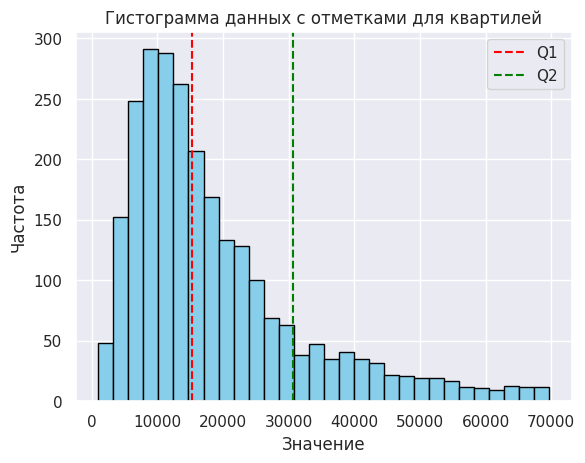

In [8]:
#Распределение признаков

group_no_season_pivot = no_season_other_clients[no_season_other_clients['year_order'] == 'заказ меньше года назад'].groupby(['inn', 'legalName', 'bid', 'first_orderdate', 'life_time', 'email', 'vid', 'recency', 'seasonality', 'type'])['orders', 'gmv', 'revenue'].agg('sum').reset_index()
group_no_season_pivot['gmv_per_order'] = group_no_season_pivot['gmv']/group_no_season_pivot['orders']


# Вычисляем квартили данных
group_no_season_q1_g = np.percentile(group_no_season_pivot['gmv_per_order'], 50)
group_no_season_q2_g = np.percentile(group_no_season_pivot['gmv_per_order'], 80)  

# Строим гистограмму
plt.hist(group_no_season_pivot['gmv_per_order'][group_no_season_pivot['gmv_per_order'] < 70000], bins=30, color='skyblue', edgecolor='black')

# Добавляем отметки для квартилей
plt.axvline(group_no_season_q1_g, color='red', linestyle='--', label='Q1')
plt.axvline(group_no_season_q2_g, color='green', linestyle='--', label='Q2')

plt.legend()
plt.title('Гистограмма данных с отметками для квартилей')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.show()

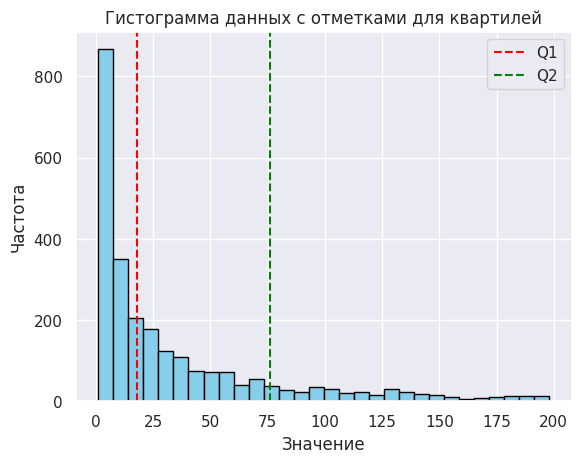

In [9]:
# Вычисляем квартили данных
group_no_season_q1_o = np.percentile(group_no_season_pivot['orders'], 50)
group_no_season_q2_o = np.percentile(group_no_season_pivot['orders'], 80)  

# Строим гистограмму
plt.hist(group_no_season_pivot['orders'][group_no_season_pivot['orders'] < 200], bins=30, color='skyblue', edgecolor='black')

# Добавляем отметки для квартилей
plt.axvline(group_no_season_q1_o, color='red', linestyle='--', label='Q1')
plt.axvline(group_no_season_q2_o, color='green', linestyle='--', label='Q2')

plt.legend()
plt.title('Гистограмма данных с отметками для квартилей')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.show()

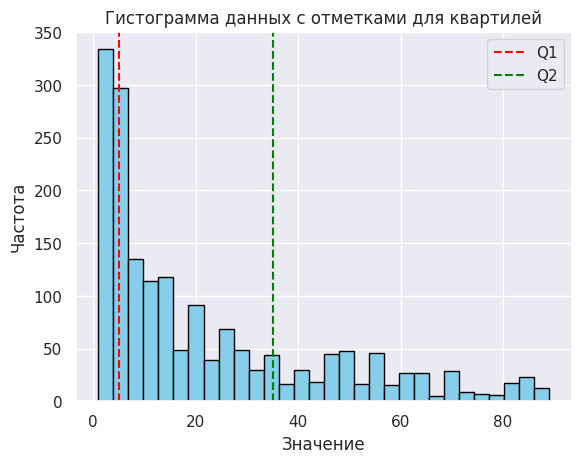

In [10]:
# Вычисляем квартили данных
group_no_season_q1_r = np.percentile(group_no_season_pivot['recency'], 20)  
group_no_season_q2_r = np.percentile(group_no_season_pivot['recency'], 50)

# Строим гистограмму
plt.hist(group_no_season_pivot['recency'][group_no_season_pivot['recency'] < 90], bins=30, color='skyblue', edgecolor='black')

# Добавляем отметки для квартилей
plt.axvline(group_no_season_q1_r, color='red', linestyle='--', label='Q1')
plt.axvline(group_no_season_q2_r, color='green', linestyle='--', label='Q2')

plt.legend()
plt.title('Гистограмма данных с отметками для квартилей')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.show()

In [11]:
def recency_category(row):
    if row['recency'] <= group_no_season_q1_r:
        return 1
    if row['recency'] > group_no_season_q1_r and row['recency'] <= group_no_season_q2_r:
        return 2
    return 3

group_no_season_pivot['recency_group'] = group_no_season_pivot.apply(recency_category, axis=1)

In [12]:
def orders_category(row):
    if row['orders'] <= group_no_season_q1_o:
        return 3
    if row['orders'] <= group_no_season_q2_o and row['orders'] > group_no_season_q1_o:
        return 2
    return 1

group_no_season_pivot['orders_group'] = group_no_season_pivot.apply(orders_category, axis=1)

In [13]:
def gmv_category(row):
    if row['gmv_per_order'] > group_no_season_q2_g:
        return 1
    if row['gmv_per_order'] <= group_no_season_q2_g and row['gmv_per_order'] > group_no_season_q1_g:
        return 2
    return 3

group_no_season_pivot['gmv_group'] = group_no_season_pivot.apply(gmv_category, axis=1)

In [14]:
#Группа признаков 

group_no_season_pivot['RFM_group'] = group_no_season_pivot['recency_group'].astype(str) + group_no_season_pivot['orders_group'].astype(str) + group_no_season_pivot['gmv_group'].astype(str)

In [15]:
#Границы для recency

print(group_no_season_q1_r, group_no_season_q2_r)

5.0 35.0


In [16]:
#Границы для gmv

print(group_no_season_q1_g, group_no_season_q2_g)

15313.032244897959 30672.967445783157


In [17]:
#Границы для orders

print(group_no_season_q1_o, group_no_season_q2_o)

18.0 76.0


In [18]:
#Распределение категорий 

group_categories_pivot = group_no_season_pivot.groupby('RFM_group')['inn'].agg('nunique').reset_index()
group_categories_pivot['share'] = group_categories_pivot['inn']/group_no_season_pivot['inn'].nunique()
group_categories_pivot.sort_values(by='inn', ascending=False)

,RFM_group,inn,share
26,333,523,0.19
25,332,276,0.10
24,331,242,0.09
14,223,185,0.07
2,113,159,0.06
23,323,137,0.05
1,112,124,0.05
13,222,117,0.04
17,233,110,0.04
5,123,97,0.04


## 3. RFM-анализ сезонной группы 

In [19]:
#Выборка сезонных

group_season_pivot = season_clients[season_clients['year_order'] == 'заказ меньше года назад'].groupby(['inn', 'legalName', 'bid', 'first_orderdate', 'life_time', 'email', 'vid', 'recency', 'seasonality', 'type'])['orders', 'gmv', 'revenue'].agg('sum').reset_index()
group_season_pivot['gmv_per_order'] = group_season_pivot['gmv']/group_season_pivot['orders']

group_season_pivot.head()


/tmp/ipykernel_223688/2192454895.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  group_season_pivot = season_clients[season_clients['year_order'] == 'заказ меньше года назад'].groupby(['inn', 'legalName', 'bid', 'first_orderdate', 'life_time', 'email', 'vid', 'recency', 'seasonality', 'type'])['orders', 'gmv', 'revenue'].agg('sum').reset_index()


,inn,legalName,bid,first_orderdate,life_time,email,vid,recency,seasonality,type,orders,gmv,revenue,gmv_per_order
0,0224954035,"ООО ""ГРЭСО""",6605b0b1-b467-489f-8807-fa1cb192aa74,2021-06-09,"1,093.00",marirmih@mail.ru,db20585e-c58f-4ef0-8b0f-172448549ebf,40,Да,больше 2 лет,11,"98,095.84","6,022.62","8,917.80"
1,0267021065,"ООО ""МОНОЛИТ""",13224534-9e17-41ed-9ac9-0466ed1b8f6f,2019-04-02,"1,919.00",monolit.sybay@yandex.ru,eb792bde-126d-49fe-8e48-fe51f5dc7005,13,Да,больше 2 лет,7,"78,057.88","4,220.98","11,151.13"
2,0278175204,"ООО ""ЭЛЕКТРОСИТИ""",5e3ad632-1999-4895-9017-2e25933065d1,2019-09-02,"1,768.00",denis_ivanov@mail.ru,5eea0e34-4e2b-4102-a3ee-ba14d1d69bbe,11,Да,больше 2 лет,31,"159,778.36","13,955.67","5,154.14"
3,0326472640,"ООО""БИЗНЕСМЕХАНИКА""",f3373b0d-8431-4468-9562-5ee7cb41feaa,2020-03-17,"1,345.00",info@cto-bm.ru,9b24e785-7b02-4622-b4ae-8d13542cfd0c,237,Да,больше 2 лет,9,"13,890.40",619.15,"1,543.38"
4,1102072630,"ООО ""СЛК""",a7955899-bb42-4961-acdf-3d1e8e31f653,2021-07-20,"1,091.00",slkmsk2018@gmail.com,188cadad-d2f9-4c39-a1cb-0bff9c74ec43,1,Да,больше 2 лет,421,"8,511,469.83","245,419.22","20,217.27"


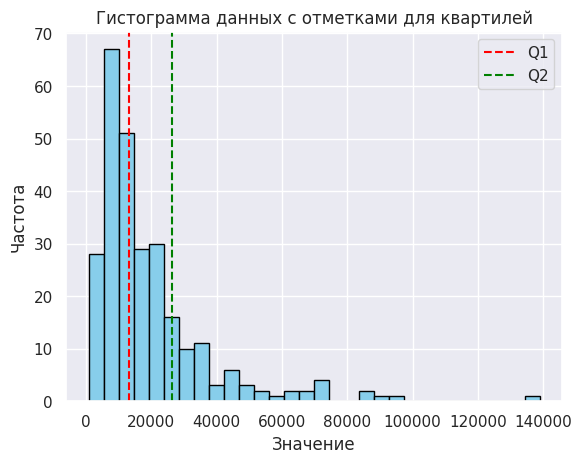

In [20]:
# Вычисляем квартили данных
group_season_q1_g = np.percentile(group_season_pivot['gmv_per_order'], 50)
group_season_q2_g = np.percentile(group_season_pivot['gmv_per_order'], 80)  

# Строим гистограмму
plt.hist(group_season_pivot['gmv_per_order'][group_season_pivot['gmv_per_order'] < 200000], bins=30, color='skyblue', edgecolor='black')

# Добавляем отметки для квартилей
plt.axvline(group_season_q1_g, color='red', linestyle='--', label='Q1')
plt.axvline(group_season_q2_g, color='green', linestyle='--', label='Q2')

plt.legend()
plt.title('Гистограмма данных с отметками для квартилей')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.show()

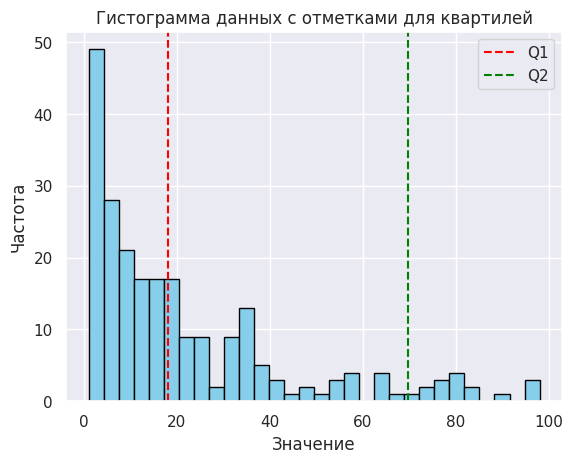

In [21]:
# Вычисляем квартили данных
group_season_q1_o = np.percentile(group_season_pivot['orders'], 50)
group_season_q2_o = np.percentile(group_season_pivot['orders'], 80)  

# Строим гистограмму
plt.hist(group_season_pivot['orders'][group_season_pivot['orders'] < 100], bins=30, color='skyblue', edgecolor='black')

# Добавляем отметки для квартилей
plt.axvline(group_season_q1_o, color='red', linestyle='--', label='Q1')
plt.axvline(group_season_q2_o, color='green', linestyle='--', label='Q2')

plt.legend()
plt.title('Гистограмма данных с отметками для квартилей')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.show()

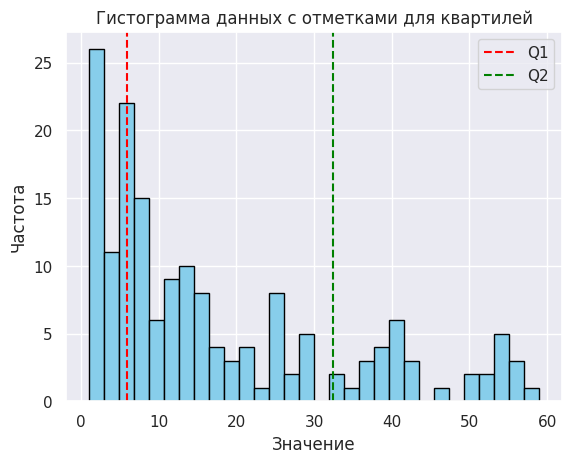

In [22]:
# Вычисляем квартили данных
group_season_q1_r = np.percentile(group_season_pivot['recency'], 20)  
group_season_q2_r = np.percentile(group_season_pivot['recency'], 50)

# Строим гистограмму
plt.hist(group_season_pivot['recency'][group_season_pivot['recency'] < 60], bins=30, color='skyblue', edgecolor='black')

# Добавляем отметки для квартилей
plt.axvline(group_season_q1_r, color='red', linestyle='--', label='Q1')
plt.axvline(group_season_q2_r, color='green', linestyle='--', label='Q2')

plt.legend()
plt.title('Гистограмма данных с отметками для квартилей')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.show()

In [23]:
def recency_category(row):
    if row['recency'] <= group_season_q1_r:
        return 1
    if row['recency'] > group_season_q2_r and row['recency'] <= group_season_q1_r:
        return 2
    return 3

group_season_pivot['recency_group'] = group_season_pivot.apply(recency_category, axis=1)

In [24]:
def orders_category(row):
    if row['orders'] <= group_season_q1_o:
        return 3
    if row['orders'] <= group_season_q2_o and row['orders'] > group_season_q1_o:
        return 2
    return 1

group_season_pivot['orders_group'] = group_season_pivot.apply(orders_category, axis=1)

In [25]:
def gmv_category(row):
    if row['gmv_per_order'] > group_season_q2_g:
        return 1
    if row['gmv_per_order'] <= group_season_q2_g and row['gmv_per_order'] > group_no_season_q1_g:
        return 2
    return 3

group_season_pivot['gmv_group'] = group_season_pivot.apply(gmv_category, axis=1)

In [26]:
#Группа признаков 

group_season_pivot['RFM_group'] = group_season_pivot['recency_group'].astype(str) + group_season_pivot['orders_group'].astype(str) + group_season_pivot['gmv_group'].astype(str)

In [27]:
#Границы для recency

print(group_season_q1_r, group_season_q2_r)

6.0 32.5


In [28]:
#Границы для gmv_order

print(group_season_q1_g, group_season_q2_g)

13106.055416666666 26372.348


In [29]:
#Границы для orders

print(group_season_q1_o, group_season_q2_o)

18.0 69.80000000000007


In [30]:
#Распределение категорий 

group_categories_pivot2 = group_season_pivot.groupby('RFM_group')['inn'].agg('nunique').reset_index()
group_categories_pivot2['share'] = group_categories_pivot2['inn']/group_season_pivot['inn'].nunique()
group_categories_pivot2.sort_values(by='inn', ascending=False)

,RFM_group,inn,share
17,333,78,0.29
14,323,30,0.11
16,332,28,0.10
15,331,24,0.09
2,113,20,0.07
13,322,18,0.07
12,321,12,0.04
11,313,9,0.03
5,123,9,0.03
1,112,9,0.03


## 4. RFM новой группы 

/tmp/ipykernel_223688/2906010559.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  new_clients_pivot = new_clients[new_clients['year_order'] == 'заказ меньше года назад'].groupby(['inn', 'legalName', 'bid', 'first_orderdate', 'life_time', 'email', 'vid', 'recency', 'seasonality', 'type'])['orders', 'gmv', 'revenue'].agg('sum').reset_index()
/tmp/ipykernel_223688/2906010559.py:6: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5578.
  stat, p = shapiro(new_clients['recency'])


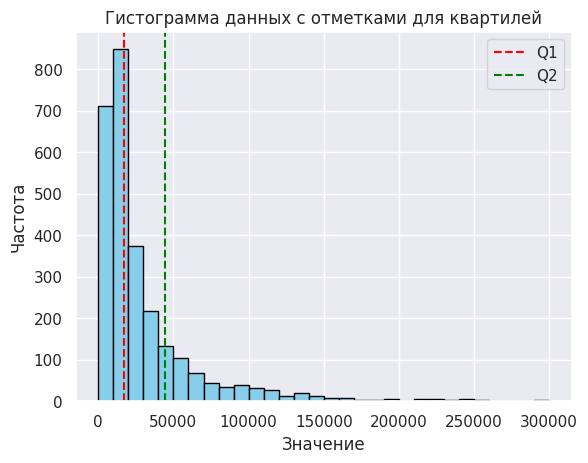

In [31]:
#Распределение признаков

new_clients_pivot = new_clients[new_clients['year_order'] == 'заказ меньше года назад'].groupby(['inn', 'legalName', 'bid', 'first_orderdate', 'life_time', 'email', 'vid', 'recency', 'seasonality', 'type'])['orders', 'gmv', 'revenue'].agg('sum').reset_index()
new_clients_pivot['gmv_per_order'] = new_clients_pivot['gmv']/new_clients_pivot['orders']

stat, p = shapiro(new_clients['recency'])

# Выводим результаты теста
#print('Статистика теста:', stat)
#print('p-значение:', p)

# Вычисляем квартили данных
new_clients_q1_g = np.percentile(new_clients_pivot['gmv_per_order'], 50)
new_clients_q2_g = np.percentile(new_clients_pivot['gmv_per_order'], 80)  

# Строим гистограмму
plt.hist(new_clients_pivot['gmv_per_order'][new_clients_pivot['gmv_per_order'] < 300000], bins=30, color='skyblue', edgecolor='black')

# Добавляем отметки для квартилей
plt.axvline(new_clients_q1_g, color='red', linestyle='--', label='Q1')
plt.axvline(new_clients_q2_g, color='green', linestyle='--', label='Q2')

plt.legend()
plt.title('Гистограмма данных с отметками для квартилей')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.show()

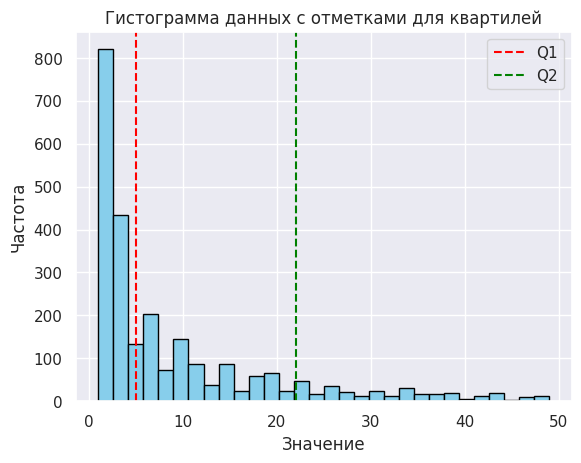

In [32]:
# Вычисляем квартили данных
new_clients_q1_o = np.percentile(new_clients_pivot['orders'], 50)
new_clients_q2_o = np.percentile(new_clients_pivot['orders'], 80)  

# Строим гистограмму
plt.hist(new_clients_pivot['orders'][new_clients_pivot['orders'] < 50], bins=30, color='skyblue', edgecolor='black')

# Добавляем отметки для квартилей
plt.axvline(new_clients_q1_o, color='red', linestyle='--', label='Q1')
plt.axvline(new_clients_q2_o, color='green', linestyle='--', label='Q2')

plt.legend()
plt.title('Гистограмма данных с отметками для квартилей')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.show()

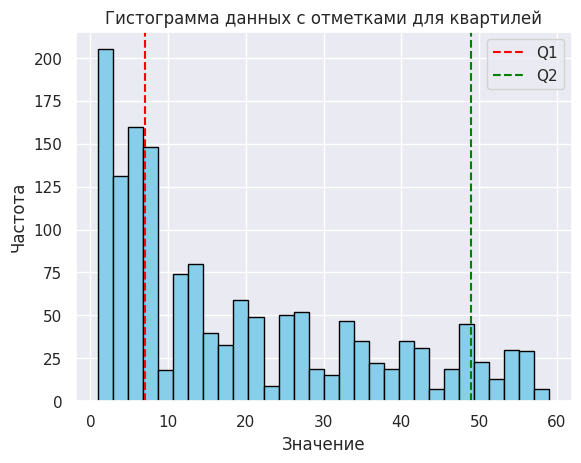

In [33]:
# Вычисляем квартили данных
new_clients_q1_r = np.percentile(new_clients_pivot['recency'], 20)  
new_clients_q2_r = np.percentile(new_clients_pivot['recency'], 50)

# Строим гистограмму
plt.hist(new_clients_pivot['recency'][new_clients_pivot['recency'] < 60], bins=30, color='skyblue', edgecolor='black')

# Добавляем отметки для квартилей
plt.axvline(new_clients_q1_r, color='red', linestyle='--', label='Q1')
plt.axvline(new_clients_q2_r, color='green', linestyle='--', label='Q2')

plt.legend()
plt.title('Гистограмма данных с отметками для квартилей')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.show()

In [34]:
def recency_category(row):
    if row['recency'] <= new_clients_q1_r:
        return 1
    if row['recency'] > new_clients_q1_r and row['recency'] <= new_clients_q2_r:
        return 2
    return 3

new_clients_pivot['recency_group'] = new_clients_pivot.apply(recency_category, axis=1)

In [35]:
def orders_category(row):
    if row['orders'] <= new_clients_q1_o:
        return 3
    if row['orders'] <= new_clients_q2_o and row['orders'] > new_clients_q1_o:
        return 2
    return 1

new_clients_pivot['orders_group'] = new_clients_pivot.apply(orders_category, axis=1)

In [36]:
def gmv_category(row):
    if row['gmv_per_order'] > group_no_season_q2_g:
        return 1
    if row['gmv_per_order'] <= group_no_season_q2_g and row['gmv_per_order'] > group_no_season_q1_g:
        return 2
    return 3

new_clients_pivot['gmv_group'] = new_clients_pivot.apply(gmv_category, axis=1)

In [37]:
#Группа признаков 

new_clients_pivot['RFM_group'] = new_clients_pivot['recency_group'].astype(str) + new_clients_pivot['orders_group'].astype(str) + new_clients_pivot['gmv_group'].astype(str)

In [38]:
#Границы для recency

print(new_clients_q1_r, new_clients_q2_r)

7.0 49.0


In [39]:
#Границы для orders

print(new_clients_q1_o, new_clients_q2_o)

5.0 22.0


In [40]:
#Границы для gmv

print(new_clients_q1_g, new_clients_q2_g)

17262.50412280702 44221.887400000014


In [41]:
#Распределение категорий 

group_categories_pivot = new_clients_pivot.groupby('RFM_group')['inn'].agg('nunique').reset_index()
group_categories_pivot['share'] = group_categories_pivot['inn']/new_clients_pivot['inn'].nunique()
group_categories_pivot.sort_values(by='inn', ascending=False)

,RFM_group,inn,share
26,333,440,0.16
24,331,332,0.12
25,332,190,0.07
2,113,150,0.05
23,323,146,0.05
17,233,136,0.05
14,223,116,0.04
15,231,113,0.04
13,222,104,0.04
12,221,98,0.04


In [42]:
new_clients_pivot['quartile_o1'] = new_clients_q1_o  
new_clients_pivot['quartile_o2'] = new_clients_q2_o   
new_clients_pivot['quartile_r1'] = new_clients_q1_r  
new_clients_pivot['quartile_r2'] = new_clients_q2_r  
new_clients_pivot['quartile_g1'] = new_clients_q1_g
new_clients_pivot['quartile_g2'] = new_clients_q2_g 

group_no_season_pivot['quartile_o1'] = group_no_season_q1_o  
group_no_season_pivot['quartile_o2'] = group_no_season_q2_o   
group_no_season_pivot['quartile_r1'] = group_no_season_q1_r  
group_no_season_pivot['quartile_r2'] = group_no_season_q2_r  
group_no_season_pivot['quartile_g1'] = group_no_season_q1_g
group_no_season_pivot['quartile_g2'] = group_no_season_q2_g 

group_season_pivot['quartile_o1'] = group_season_q1_o  
group_season_pivot['quartile_o2'] = group_season_q2_o   
group_season_pivot['quartile_r1'] = group_season_q1_r  
group_season_pivot['quartile_r2'] = group_season_q2_r  
group_season_pivot['quartile_g1'] = group_season_q1_g
group_season_pivot['quartile_g2'] = group_season_q2_g 

In [43]:
data_all1 = pd.concat([group_no_season_pivot, new_clients_pivot], axis=0)
data_final = pd.concat([data_all1, group_season_pivot], axis=0)


In [44]:
def recency_desc(row):
    if row['recency'] <= row['quartile_r1']:
        return 'недавний'
    if row['recency'] > row['quartile_r1'] and row['recency'] <= row['quartile_r2']:
        return 'среднедавний'
    return 'давний'

data_final['recency_desc'] = data_final.apply(recency_desc, axis=1)


def orders_desc(row):
    if row['orders'] <= row['quartile_o1']:
        return 'наименее частотный'
    if row['orders'] > row['quartile_o1'] and row['orders'] <= row['quartile_o2']:
        return 'частотный'
    return 'наиболее частотный'

data_final['orders_desc'] = data_final.apply(orders_desc, axis=1)


def gmv_desc(row):
    if row['gmv_per_order'] <= row['quartile_g1']:
        return 'наименее денежный'
    if row['gmv_per_order'] > row['quartile_g1'] and row['gmv_per_order'] <= row['quartile_g2']:
        return 'денежный'
    return 'наиболее денежный'

data_final['gmv_desc'] = data_final.apply(gmv_desc, axis=1)

In [45]:
data_final['first_orderdate'] = pd.to_datetime(data_final['first_orderdate'])
data_final = data_final[['first_orderdate', 'inn', 'legalName', 'email', 'RFM_group', 'recency_desc', 'orders_desc', 'gmv_desc', 'seasonality', 'gmv', 'revenue', 'gmv_per_order', 'orders', 'recency']]
data_final.to_csv('RFM-анализ.csv', index=False)

In [46]:
query0 = f"""copy tmp.ak_b2b_rfm_analysis (first_orderdate, inn, legalName, email, RFM_group, recency_desc, orders_desc, gmv_desc, seasonality, gmv, revenue, gmv_per_order, orders, recency) from local '/home/jupyter-anastasiya.kobtsev-3a1bd/RFM-анализ.csv' delimiter ',' skip 1;"""

In [47]:
pd.read_sql(query0, connection)

/tmp/ipykernel_223688/3892824991.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(query0, connection)


,Rows Loaded
0,5718
